[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/langchain-ai/langchain-academy/blob/main/module-3/streaming-interruption.ipynb) [![Open in LangChain Academy](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66e9eba12c7b7688aa3dbb5e_LCA-badge-green.svg)](https://academy.langchain.com/courses/take/intro-to-langgraph/lessons/58239464-lesson-1-streaming)

# Streaming

## Review

In module 2, covered a few ways to customize graph state and memory.
 
We built up to a Chatbot with external memory that can sustain long-running conversations. 

## Goals

This module will dive into `human-in-the-loop`, which builds on memory and allows users to interact directly with graphs in various ways. 

To set the stage for `human-in-the-loop`, we'll first dive into streaming, which provides several ways to visualize graph output (e.g., node state or chat model tokens) over the course of execution.

In [1]:
%%capture --no-stderr
%pip install --quiet -U langgraph langchain_openai langgraph_sdk

## Streaming

LangGraph is built with [first class support for streaming](https://docs.langchain.com/oss/python/langgraph/streaming).

Let's set up our Chatbot from Module 2, and show various way to stream outputs from the graph during execution. 

In [2]:
import os, getpass

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("OPENAI_API_KEY")

Note that we use `RunnableConfig` with `call_model` to enable token-wise streaming. This is [only needed with python < 3.11](https://langchain-ai.github.io/langgraph/how-tos/streaming-tokens/). We include in case you are running this notebook in CoLab, which will use python 3.x. 

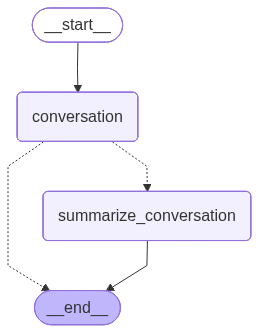

In [3]:
from IPython.display import Image, display
from typing import Literal

from langchain_openai import ChatOpenAI
from langchain_core.messages import SystemMessage, HumanMessage, RemoveMessage
from langchain_core.runnables import RunnableConfig

from langgraph.checkpoint.memory import InMemorySaver
from langgraph.graph import StateGraph, START, END
from langgraph.graph import MessagesState

# LLM
model = ChatOpenAI(model="gpt-5-nano", temperature=0) 

# State 
class State(MessagesState):
    summary: str

# Define the logic to call the model
def call_model(state: State, config: RunnableConfig):
    
    # Get summary if it exists
    summary = state.get("summary", "")

    # If there is summary, then we add it
    if summary:
        
        # Add summary to system message
        system_message = f"Summary of conversation earlier: {summary}"

        # Append summary to any newer messages
        messages = [SystemMessage(content=system_message)] + state["messages"]
    
    else:
        messages = state["messages"]
    
    response = model.invoke(messages, config)
    return {"messages": response}

def summarize_conversation(state: State):
    
    # First, we get any existing summary
    summary = state.get("summary", "")

    # Create our summarization prompt 
    if summary:
        
        # A summary already exists
        summary_message = (
            f"This is summary of the conversation to date: {summary}\n\n"
            "Extend the summary by taking into account the new messages above:"
        )
        
    else:
        summary_message = "Create a summary of the conversation above:"

    # Add prompt to our history
    messages = state["messages"] + [HumanMessage(content=summary_message)]
    response = model.invoke(messages)
    
    # Delete all but the 2 most recent messages
    delete_messages = [RemoveMessage(id=m.id) for m in state["messages"][:-2]]
    return {"summary": response.content, "messages": delete_messages}

# Determine whether to end or summarize the conversation
def should_continue(state: State)-> Literal ["summarize_conversation",END]:
    
    """Return the next node to execute."""
    
    messages = state["messages"]
    
    # If there are more than six messages, then we summarize the conversation
    if len(messages) > 6:
        return "summarize_conversation"
    
    # Otherwise we can just end
    return END

# Define a new graph
workflow = StateGraph(State)
workflow.add_node("conversation", call_model)
workflow.add_node(summarize_conversation)

# Set the entrypoint as conversation
workflow.add_edge(START, "conversation")
workflow.add_conditional_edges("conversation", should_continue)
workflow.add_edge("summarize_conversation", END)

# Compile
memory = InMemorySaver()
graph = workflow.compile(checkpointer=memory)
display(Image(graph.get_graph().draw_mermaid_png()))

### Streaming full state

Now, let's talk about ways to [stream our graph state](https://docs.langchain.com/oss/python/langgraph/streaming#supported-stream-modes).

`.stream` and `.astream` are sync and async methods for streaming back results. 
 
LangGraph supports a few [different streaming modes](https://docs.langchain.com/oss/python/langgraph/streaming#stream-graph-state) for graph state.
 
* `values`: This streams the full state of the graph after each node is called.
* `updates`: This streams updates to the state of the graph after each node is called.

![values_vs_updates.png](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66dbaf892d24625a201744e5_streaming1.png)

Let's look at `stream_mode="updates"`.

Because we stream with `updates`, we only see updates to the state after node in the graph is run.

Each `chunk` is a dict with `node_name` as the key and the updated state as the value.

In [4]:
# Create a thread
config = {"configurable": {"thread_id": "1"}}

# Start conversation
for chunk in graph.stream({"messages": [HumanMessage(content="hi! I'm Shiv")]}, 
                          config, 
                          stream_mode="updates"):
    print(chunk)

{'conversation': {'messages': AIMessage(content='Hi Shiv! Nice to meet you. How can I help today? I can explain concepts, draft or edit text, help with coding, plan a project, answer questions, or just chat. Tell me a bit about what you’re working on or what you’d like to do, and we’ll dive in. What would you like to start with?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 464, 'prompt_tokens': 10, 'total_tokens': 474, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 384, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_provider': 'openai', 'model_name': 'gpt-5-nano-2025-08-07', 'system_fingerprint': None, 'id': 'chatcmpl-CqVFKNbUAu1hzmWZrqbPD5oSq4xID', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='lc_run--019b534e-57c8-7532-bbad-4c387a8f4141-0', usage_metadata={'input_tokens': 10, 'output_tokens':

Let's now just print the state update.

In [5]:
# Start conversation
for chunk in graph.stream({"messages": [HumanMessage(content="hi! I'm Shiv")]}, 
                          config, 
                          stream_mode="updates"):
    chunk['conversation']["messages"].pretty_print()

================================== Ai Message ==================================

Hi Shiv! Nice to chat again. What would you like to work on today? Here are some easy options:

- Explain a concept or topic
- Draft or edit a message, essay, or code note
- Help with programming or debugging
- Plan a project or study path
- Brainstorm ideas or practice a skill (writing, coding, learning)

Tell me your goal or just say what you’re curious about and we’ll dive in.


Now, we can see `stream_mode="values"`.

This is the `full state` of the graph after the `conversation` node is called.

In [ ]:
config = {"configurable": {"thread_id": 2}}
# returns full state
input_message = HumanMessage(content = "hi! I'm Shiv")
for event in graph.stream({"messages": [input_message]}, config, stream_mode = "values"):
    for m in event['messages']:
        m.pretty_print()
    print("---"*25)

================================ Human Message =================================

hi! I'm Shiv
---------------------------------------------------------------------------
================================ Human Message =================================

hi! I'm Shiv
================================== Ai Message ==================================

Hi Shiv! Nice to meet you. I’m ChatGPT. How can I help today? I can answer questions, brainstorm ideas, explain concepts, draft messages, help with coding, plan projects, or just chat. Tell me what you’d like to work on or ask me anything.
---------------------------------------------------------------------------


### Streaming tokens

We often want to stream more than graph state.

In particular, with chat model calls it is common to stream the tokens as they are generated.

We can do this [using the `.astream_events` method](https://docs.langchain.com/oss/python/langchain/models#advanced-streaming-topics:streaming-events), which streams back events as they happen inside nodes!

Each event is a dict with a few keys:
 
* `event`: This is the type of event that is being emitted. 
* `name`: This is the name of event.
* `data`: This is the data associated with the event.
* `metadata`: Contains`langgraph_node`, the node emitting the event.

Let's have a look.

In [9]:
config = {"configurable": {"thread_id": "3"}}
input_message = HumanMessage(content="Tell me about the Shiv Maha Puran")
async for event in graph.astream_events({"messages": [input_message]}, config, version="v2"):
    print(f"Node: {event['metadata'].get('langgraph_node','')}. Type: {event['event']}. Name: {event['name']}")

Node: . Type: on_chain_start. Name: LangGraph
Node: conversation. Type: on_chain_start. Name: conversation
Node: conversation. Type: on_chat_model_start. Name: ChatOpenAI
Node: conversation. Type: on_chat_model_stream. Name: ChatOpenAI
Node: conversation. Type: on_chat_model_stream. Name: ChatOpenAI
Node: conversation. Type: on_chat_model_stream. Name: ChatOpenAI
Node: conversation. Type: on_chat_model_stream. Name: ChatOpenAI
Node: conversation. Type: on_chat_model_stream. Name: ChatOpenAI
Node: conversation. Type: on_chat_model_stream. Name: ChatOpenAI
Node: conversation. Type: on_chat_model_stream. Name: ChatOpenAI
Node: conversation. Type: on_chat_model_stream. Name: ChatOpenAI
Node: conversation. Type: on_chat_model_stream. Name: ChatOpenAI
Node: conversation. Type: on_chat_model_stream. Name: ChatOpenAI
Node: conversation. Type: on_chat_model_stream. Name: ChatOpenAI
Node: conversation. Type: on_chat_model_stream. Name: ChatOpenAI
Node: conversation. Type: on_chat_model_stream. N

The central point is that tokens from chat models within your graph have the `on_chat_model_stream` type.

We can use `event['metadata']['langgraph_node']` to select the node to stream from.

And we can use `event['data']` to get the actual data for each event, which in this case is an `AIMessageChunk`. 

In [10]:
node_to_stream = 'conversation'
config = {"configurable": {"thread_id": "4"}}
input_message = HumanMessage(content="Tell me about the Shiv Maha Puran")
async for event in graph.astream_events({"messages": [input_message]}, config, version="v2"):
    # Get chat model tokens from a particular node 
    if event["event"] == "on_chat_model_stream" and event['metadata'].get('langgraph_node','') == node_to_stream:
        print(event["data"])

{'chunk': AIMessageChunk(content='', additional_kwargs={}, response_metadata={'model_provider': 'openai'}, id='lc_run--019b5358-da1b-75b2-817e-ee28a56d23d1')}
{'chunk': AIMessageChunk(content='Sh', additional_kwargs={}, response_metadata={'model_provider': 'openai'}, id='lc_run--019b5358-da1b-75b2-817e-ee28a56d23d1')}
{'chunk': AIMessageChunk(content='iva', additional_kwargs={}, response_metadata={'model_provider': 'openai'}, id='lc_run--019b5358-da1b-75b2-817e-ee28a56d23d1')}
{'chunk': AIMessageChunk(content=' Pur', additional_kwargs={}, response_metadata={'model_provider': 'openai'}, id='lc_run--019b5358-da1b-75b2-817e-ee28a56d23d1')}
{'chunk': AIMessageChunk(content='ana', additional_kwargs={}, response_metadata={'model_provider': 'openai'}, id='lc_run--019b5358-da1b-75b2-817e-ee28a56d23d1')}
{'chunk': AIMessageChunk(content=',', additional_kwargs={}, response_metadata={'model_provider': 'openai'}, id='lc_run--019b5358-da1b-75b2-817e-ee28a56d23d1')}
{'chunk': AIMessageChunk(content=

As you see above, just use the `chunk` key to get the `AIMessageChunk`.

In [11]:
config = {"configurable": {"thread_id": "5"}}
input_message = HumanMessage(content="Tell me about the Shiv Maha Puran")
async for event in graph.astream_events({"messages": [input_message]}, config, version="v2"):
    # Get chat model tokens from a particular node 
    if event["event"] == "on_chat_model_stream" and event['metadata'].get('langgraph_node','') == node_to_stream:
        data = event["data"]
        print(data["chunk"].content, end="|")

|Here|’s| a| concise| overview| of| the| Shiv| Maha| P|uran| (|Sh|iva| Pur|ana|):

|-| What| it| is|
| | -| One| of| the| major| P|uran|as| in| Hindu|ism|,| and| the| primary| scripture| for| Sha|iv|ism|.| It| centers| on| Lord| Shiva|,| his| forms|,| his| deeds|,| and| his| worship|.
| | -| Part| of| the| traditional| list| of| |18| Mah|ap|uran|as|.| It| exists| in| multiple| rec|ensions|,| with| variations| in| order| and| content|.

|-| What| it| covers|
| | -| The| nature| and| greatness| of| Shiva|,| including| his| forms| (|like| N|atar|aja|,| Mah|esh|vara|)| and| his| wife| Par|vati|.
| | -| Legends| about| Shiva|,| Par|vati|,| and| their| sons| G|anes|ha| and| Kart|ik|eya|.
| | -| Creation|,| destruction|,| and| the| cosmic| order| from| a| Sha|iva| perspective|.
| | -| The| significance| of| the| ling|am| as| a| symbol| of| Shiva| and| guidance| on| temple| worship| and| ritual| practices| (|abh|is|heka|,| pu|ja|,| etc|.).
| | -| Stories| about| holy| places| and| pilgrimage|,